In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from tqdm import tqdm
from scipy.constants import fine_structure, speed_of_light, electron_mass, elementary_charge, hbar, epsilon_0

In [2]:
#variáveis e constantes
electron_radius = elementary_charge**2/(4*pi*epsilon_0*electron_mass*speed_of_light**2)
num_pon = 200                                                   #número de pontos
mag_field = 5e2                                                 #[T] intensidade do campo magnético
tau_e = hbar/(speed_of_light**2*electron_mass)                  #[s] tempo que demora à luz para viajar o raio de um eletrão
t_end = 7.6e2                                                   #[s] tempo final
t_steps = 5000                                                  #numero de steps
t_int = t_end/t_steps                                           #[s] intervalo de tempo
min_ene = 1                                                     #[] energia mínima
max_ene = 400/(0.000511)                                        #[] energia máxima
d_ene = (max_ene-min_ene)/num_pon                               #intervalo de energia

time_lst = np.linspace(0, t_end, t_steps)
enelst = np.linspace(min_ene, max_ene, num_pon)

In [3]:
def getEnergy(x):
    return np.trapz(x*enelst, enelst)/np.trapz(x, enelst)

def getNumber(f):
    return np.trapz(f, enelst)

def getChi(f):
    return np.trapz(f * enelst, enelst) / (
                np.trapz(f, enelst) + 1e-12) * cnst_prop_2(mag_field)
   
def cnst_prop_2(mag):
    return mag/(4.5*10**(9))

#equacao 3.83 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def G_tilde_int(chi, epsilon):
    v = 2 * epsilon / (3 * chi * (1 - epsilon))
    return np.sqrt(3) / (2 * pi) * epsilon * (
                integrate.quad(lambda x: sp.kv(5 / 3, x), v, np.inf)[
                    0] + 1.5 * epsilon * chi * v * sp.kv(2 / 3, v))

G_tilde_int_vec_aux = lambda chi1, epsilon1: G_tilde_int(chi1, epsilon1)

G_tilde_int_vec = np.vectorize(G_tilde_int_vec_aux)

#equacao 3.82 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def dN_dg(chi, epsilon):
    omega_c = elementary_charge / electron_mass/1800**2 * mag_field * max_ene
    if chi/cnst_prop_2(mag_field) <= d_ene or epsilon * chi/cnst_prop_2(mag_field) <= d_ene or epsilon >= 1 or epsilon <= 0:
        return 0
    return (2 / 3) * fine_structure / tau_e / omega_c * G_tilde_int_vec(chi, epsilon) / (epsilon * (chi/cnst_prop_2(mag_field))**2)

In [4]:
dfdt_mat = np.zeros((num_pon, num_pon))
dfdt_mat_11_i = np.zeros_like(dfdt_mat)
dfdt_mat_11_o = np.zeros_like(dfdt_mat)

for i in range(num_pon):
    dfdt_mat_11_o[i, i] = -np.sum(np.array([dN_dg(enelst[i]*cnst_prop_2(mag_field), g/enelst[i]) for g in enelst[enelst<enelst[i]]])) * d_ene

for i in range(num_pon):
    for j in range(i, num_pon):
        dfdt_mat_11_i[i, j] = dN_dg(enelst[j]*cnst_prop_2(mag_field), (enelst[j] - enelst[i])/enelst[j]) * d_ene

dfdt_mat = dfdt_mat_11_i+dfdt_mat_11_o

def dfdt(yn):
    return np.matmul(dfdt_mat, yn)

In [5]:
#condicoes iniciais
yn = np.zeros(num_pon)
yn[np.abs(enelst-max_ene).argmin()] = 1

ene_lst_final = np.zeros(t_steps)
chi_lst_final = np.zeros(t_steps)
num_lst_final = np.zeros(t_steps)

ffiga = np.zeros((t_steps, num_pon))
ffiga[0,:] = yn

ene_lst_final[0] = getEnergy(yn[:num_pon])/max_ene
chi_lst_final[0] = getChi(yn[:num_pon])/(max_ene*cnst_prop_2(mag_field))
num_lst_final[0] = getNumber(yn[:num_pon])/num_pon

#RK4
for t in tqdm(range(1, t_steps)):
    k1 = dfdt(yn)
    k2 = dfdt(yn + t_int * k1 / 2)
    k3 = dfdt(yn + t_int * k2 / 2)
    k4 = dfdt(yn + t_int * k3)
    yn = yn + t_int / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    yn[yn <= 0] = 0

    ene_lst_final[t] = getEnergy(yn)/max_ene
    chi_lst_final[t] = getChi(yn) / (max_ene * cnst_prop_2(mag_field))
    num_lst_final[t] = getNumber(yn) / num_pon

    ffiga[t, :] = yn

<ipython-input-5-1e52da43de33>:17: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for t in tqdm(range(1, t_steps)):
100%|██████████| 4999/4999 [00:02<00:00, 1939.10it/s]


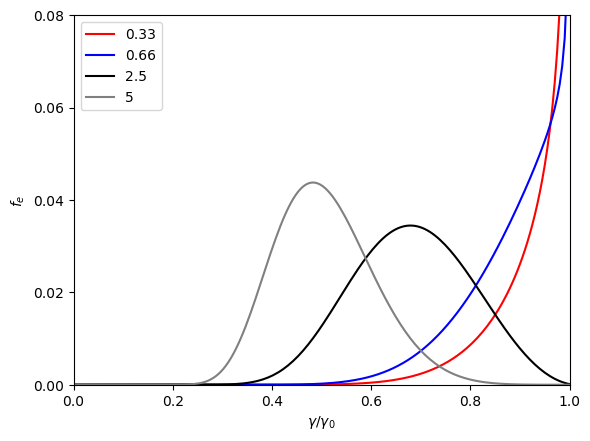

In [6]:
plt.plot(enelst/max_ene, 0.65*num_pon/60*ffiga[int(t_steps*0.33/5)], label=r'0.33', color = 'red')
plt.plot(enelst/max_ene, 0.65*num_pon/60*ffiga[int(t_steps*0.66/5)], label=r'0.66', color = 'blue')
plt.plot(enelst/max_ene, 0.65*num_pon/60*ffiga[int(t_steps*2.5/5)], label=r'2.5', color = 'black')
plt.plot(enelst/max_ene, 0.65*num_pon/60*ffiga[int(t_steps*4.999/5)], label=r'5', color = 'gray')
plt.xlabel("${\gamma}/{\gamma_0}$")
plt.ylabel("$f_e$")
plt.legend()
plt.ylim(0, 0.08)
plt.xlim(0, 1)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.02, 0.04, 0.06, 0.08])

plt.show()

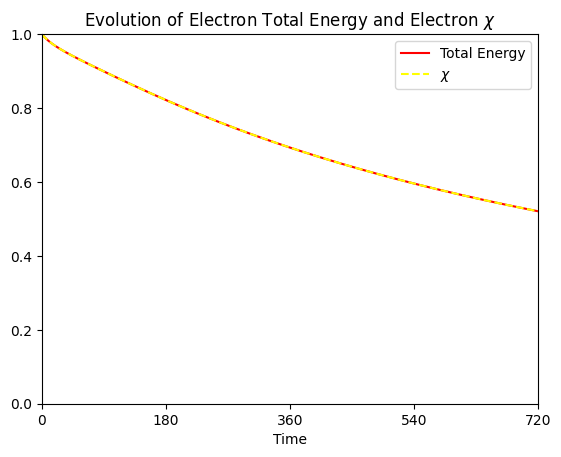

In [7]:
plt.title("Evolution of Electron Total Energy and Electron $\chi$")
plt.plot(time_lst, ene_lst_final, label=r'Total Energy', color='red', linestyle='solid')
plt.plot(time_lst, chi_lst_final, label=r'$\chi$', color='yellow', linestyle='dashed')
plt.xlabel("Time")
plt.ylim(0, 1)
plt.xlim(0, 720)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([0, 180, 360, 540, 720])
plt.legend()

plt.show()